In [28]:
# imports
import os
import glob
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# extracting features - vibrations
def extract_features(signal: np.ndarray) -> dict:
    return {
        "mean": np.mean(signal),
        "std": np.std(signal),
        "var": np.var(signal),
        "rms": np.sqrt(np.mean(signal**2)),
        "max": np.max(signal),
        "min": np.min(signal),
        "skew": pd.Series(signal).skew(),
        "kurt": pd.Series(signal).kurtosis(),
    }

In [30]:
# loading data
def load_dataset(base_path: str):
    X = []
    y = []

    # normal
    normal_path = os.path.join(base_path, "normal")
    normal_files = glob.glob(os.path.join(normal_path, "*.csv"))

    for file in normal_files:
        signal = pd.read_csv(file, header=None).values.flatten()
        features = extract_features(signal)
        X.append(features)
        y.append("normal")

    # imbalance and subfolders
    imbalance_path = os.path.join(base_path, "imbalance")
    imbalance_folders = os.listdir(imbalance_path)

    for folder in imbalance_folders:
        folder_path = os.path.join(imbalance_path, folder)
        files = glob.glob(os.path.join(folder_path, "*.csv"))

    for file in files:
        signal = pd.read_csv(file, header=None).values.flatten()
        features = extract_features(signal)
        X.append(features)
        y.append("imbalance")

    return pd.DataFrame(X), pd.Series(y)

In [31]:
# path
BASE_PATH = "/Users/pedrocm/Downloads/archive"

X, y = load_dataset(BASE_PATH)

print(X.shape)
print(y.value_counts())

(98, 8)
normal       49
imbalance    49
Name: count, dtype: int64


In [32]:
# sizes and states for test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [33]:
print(X_train.dtypes) 
'''Forgot to do np.mean at rms so it treated like an obj'''
# calling SS
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mean    float64
std     float64
var     float64
rms     float64
max     float64
min     float64
skew    float64
kurt    float64
dtype: object


In [ ]:
# training Random Forest
rf = RandomForestClassifier(
    n_estimators=200, 
    random_state=42, 
    class_weight="balanced"
)

rf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=2000,
                       random_state=42)

In [35]:
# evaluating
y_pred = rf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   imbalance       0.92      0.73      0.81        15
      normal       0.78      0.93      0.85        15

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30



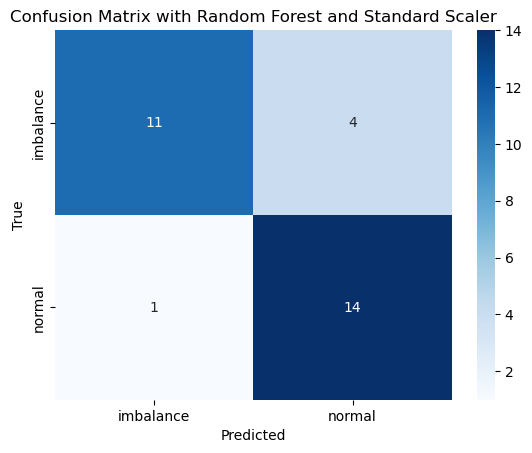

In [36]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=rf.classes_,
    yticklabels=rf.classes_
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix with Random Forest and Standard Scaler")
plt.show()